[LightGBM] [Info] Number of positive: 628241, number of negative: 188754
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3823
[LightGBM] [Info] Number of data points in the train set: 816995, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.768966 -> initscore=1.202479
[LightGBM] [Info] Start training from score 1.202479
[LightGBM] [Info] Number of positive: 628241, number of negative: 188754
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3911
[LightGBM] [Info] Number of data points in the train set: 816995, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.768966 -> initscore=1.202479
[LightGBM] [Info] Start training from score 1.202479
[LightGBM]

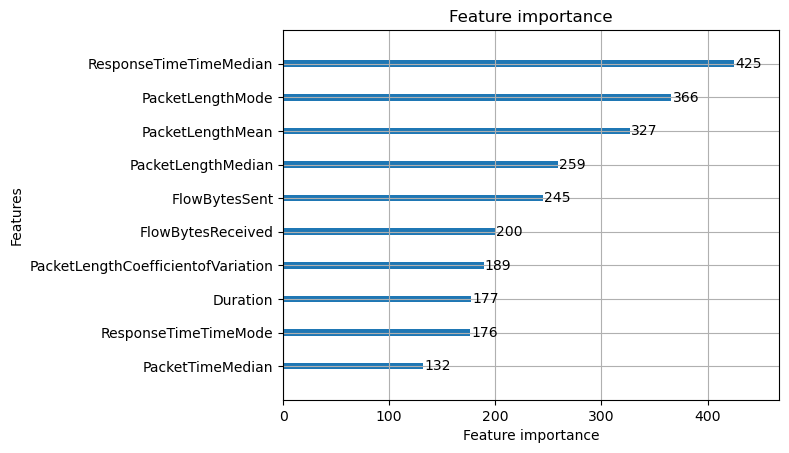

Selected Features: ['Duration', 'FlowBytesSent', 'FlowBytesReceived', 'PacketLengthMean', 'PacketLengthMedian', 'PacketLengthMode', 'PacketLengthSkewFromMedian', 'PacketLengthSkewFromMode', 'PacketLengthCoefficientofVariation', 'PacketTimeStandardDeviation', 'PacketTimeMedian', 'PacketTimeMode', 'PacketTimeSkewFromMedian', 'PacketTimeCoefficientofVariation', 'ResponseTimeTimeVariance', 'ResponseTimeTimeStandardDeviation', 'ResponseTimeTimeMedian', 'ResponseTimeTimeMode', 'ResponseTimeTimeCoefficientofVariation']
Dropped Features due to High Correlation: ['PacketTimeStandardDeviation']
Correlation Matrix:
                                         Duration  FlowBytesSent  \
Duration                                1.000000       0.377674   
FlowBytesSent                           0.377674       1.000000   
FlowBytesReceived                       0.108222       0.261708   
PacketLengthMean                        0.020379       0.021019   
PacketLengthMedian                      0.009167    

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from deap import base, creator, tools, algorithms
import lightgbm as lgb

# Load the datasets
doh_df = pd.read_csv('l1-doh.csv')
non_doh_df = pd.read_csv('l1-nondoh.csv')

# Combine the datasets
df = pd.concat([doh_df, non_doh_df], ignore_index=True)

# Drop unnecessary columns
df = df.drop(columns=['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp'])

# Encode the labels
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Split the data into features and labels
X = df.drop(columns=['Label'])
y = df['Label']

# Define the fitness function
def evaluate(individual):
    selected_features = [feature for feature, select in zip(X.columns, individual) if select]
    if len(selected_features) == 0:
        return 0,
    X_selected = X[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
    model = lgb.LGBMClassifier()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy,

# Setup genetic algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

population = toolbox.population(n=50)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False)

# Get the best individual
best_individual = tools.selBest(population, 1)[0]
selected_features = [feature for feature, select in zip(X.columns, best_individual) if select]

# Correlation matrix
corr_matrix = X[selected_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_selected = X[selected_features].drop(columns=to_drop)

# Train the final model
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Output results
accuracy = accuracy_score(y_test, predictions)
class_report = classification_report(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

# Plot feature importance
lgb.plot_importance(model, max_num_features=10)
plt.title('Feature importance')
plt.show()

# Display results
print("Selected Features:", selected_features)
print("Dropped Features due to High Correlation:", to_drop)
print("Correlation Matrix:\n", corr_matrix)
print("Accuracy Score:", accuracy)
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)
